In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split 

from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

from GeneticAlgorithm import GeneticAlgorithm
from utils import ProcessData



# Importing/processing real data

In [2]:
prodat = ProcessData()

df = pd.read_excel('Tg_data.xlsx')

X = pd.read_excel('CountMatrix_X.xlsx', index_col=0)
fragnames = X.columns

D = pd.read_excel('Descriptors_D.xlsx', index_col=0).iloc[:,2:]
new_ind = [prodat.hyphen_to_brackets(ind) for ind in D.index]
D.index = new_ind
D = D.reindex(fragnames)

In [3]:
smis = [prodat.to_smiles(frag, end_cap='*') for frag in fragnames]
mols = [Chem.MolFromSmiles(smi) for smi in smis]
mass = pd.Series([rdMolDescriptors.CalcExactMolWt(mol) for mol in mols], index=fragnames)

In [4]:
Xn = (X @ pd.DataFrame(np.diag(mass), columns=fragnames, index=fragnames)).div(X @ mass, axis=0) # mass composition matrix

In [5]:
R = Xn @ D # inputs
TgK = df['Avg. Tg in Kelvin'] # response
print(R.shape)

(146, 213)


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.53it/s]

Selected features: ['Mor10', 'Mor19m', 'Mor21m', 'Mor13v']


Text(0.5, 1.0, 'GA Fitness over Generations')

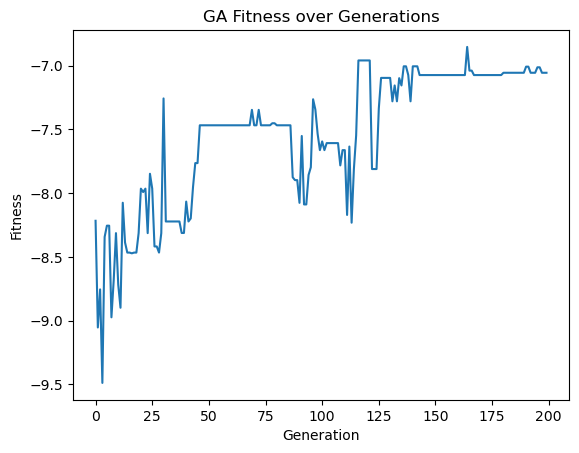

In [49]:
# Split into train/test
R_train, R_test, y_train, y_test = train_test_split(
    R, TgK, test_size=0.3, random_state=0
)

# 2. Run GA
ga = GeneticAlgorithm(
    population_size=50,
    max_gen=200,
    initial_ones=4,
    selection_type='roulette wheel',
    crossover_type='constrained',
    mutation_rate_per_pop=0.3,
    mutation_rate_per_chromosome=0.1
)
ga.fit(R_train, y_train, R_test, y_test) # GA uses prediction accuracy on test set to calculate the fitness

# 3. Output results
print("Selected features:", list(ga.best_features))

# 4. Plot fitness curve
fig, ax = ga.plot_fitness()
ax.set_title("GA Fitness over Generations")
    